#### Normal CNN for the Bird classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
DIR_TRAIN = '../Data/Use/Train/'
DIR_VALID = '../Data/Use/Valid/'

In [4]:
os.listdir(DIR_VALID)

['CASPIAN TERN',
 'D-ARNAUDS BARBET',
 'DARK EYED JUNCO',
 'HOUSE FINCH',
 'OVENBIRD',
 'OYSTER CATCHER',
 'RED TAILED HAWK',
 'SWINHOES PHEASANT',
 'VIOLET GREEN SWALLOW',
 'WOOD DUCK']

In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_datagen = train_datagen.flow_from_directory(DIR_TRAIN,
                                                target_size=(224,224), 
                                                color_mode='rgb', 
                                                class_mode='categorical', 
                                                batch_size=16,
                                                shuffle=True)

valid_datagen = valid_datagen.flow_from_directory(DIR_VALID,
                                                target_size=(224,224), 
                                                color_mode='rgb', 
                                                class_mode='categorical', 
                                                batch_size=16,
                                                shuffle=True)

Found 1000 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [22]:
class ConvNet(tf.keras.Model):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.layer = [
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(4,4), strides=(4,4)),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(4,4), strides=(4,4)),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(10, activation='softmax')
        ]

    def call(self, x):

        for i in self.layer:
            x = i(x)
        return x

In [23]:
net = ConvNet()

net.build(input_shape=(16, 224, 224, 3))
net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
net.fit(train_datagen, epochs=100, validation_data=valid_datagen)

Epoch 1/100
63/63 [==============================] - 3s 43ms/step - loss: 2.1982 - accuracy: 0.4480 - val_loss: 3.7954 - val_accuracy: 0.1200
Epoch 2/100
63/63 [==============================] - 2s 37ms/step - loss: 1.4608 - accuracy: 0.6650 - val_loss: 8.2285 - val_accuracy: 0.1000
Epoch 3/100
63/63 [==============================] - 2s 39ms/step - loss: 0.8419 - accuracy: 0.7820 - val_loss: 7.3043 - val_accuracy: 0.1800
Epoch 4/100
63/63 [==============================] - 2s 37ms/step - loss: 0.5585 - accuracy: 0.8450 - val_loss: 16.8409 - val_accuracy: 0.1400
Epoch 5/100
63/63 [==============================] - 3s 41ms/step - loss: 0.4235 - accuracy: 0.9040 - val_loss: 18.8673 - val_accuracy: 0.1600
Epoch 6/100
63/63 [==============================] - 2s 39ms/step - loss: 0.3998 - accuracy: 0.9000 - val_loss: 16.0086 - val_accuracy: 0.3000
Epoch 7/100
63/63 [==============================] - 3s 39ms/step - loss: 0.3241 - accuracy: 0.9090 - val_loss: 18.2650 - val_accuracy: 0.2200
Ep

#### Predicting a bird

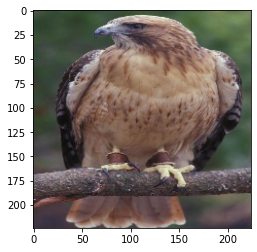

In [126]:
# Load a random image
path = np.random.choice(os.listdir(DIR_VALID))
img = np.random.choice(os.listdir(DIR_VALID + path))
img = Image.open(DIR_VALID + path + '/' + img)

plt.imshow(img)

img = tf.expand_dims(img, 0)
img = tf.cast(img, tf.float32)
img = img / 255.0

In [127]:
preds = net.predict(img)
preds_dict = {}

for n,i in enumerate(preds[0]):
    preds_dict[os.listdir(DIR_VALID)[n]] = i

preds_dict = sorted(preds_dict.items(), key=lambda x: x[1], reverse=True)

print('Actual:', path, '- Predicted:', os.listdir(DIR_VALID)[np.argmax(preds[0])],'\n')

for i in preds_dict:
    print(f'{i[1]:.2f}', i[0])

Actual: RED TAILED HAWK - Predicted: RED TAILED HAWK 

0.12 RED TAILED HAWK
0.12 OYSTER CATCHER
0.11 DARK EYED JUNCO
0.10 OVENBIRD
0.10 HOUSE FINCH
0.10 VIOLET GREEN SWALLOW
0.09 D-ARNAUDS BARBET
0.09 CASPIAN TERN
0.09 SWINHOES PHEASANT
0.08 WOOD DUCK
